# Vision Transformer (ViT)

El Vision Transformer (ViT), propuesto por Dosovitskiy et al. (2020), utiliza una arquitectura basada en Transformers para tareas de visión por computadora. A diferencia de las CNN, el ViT aplica **Multi-Head Self-Attention (MHSA)** para modelar relaciones globales entre partes de la imagen.

## Arquitectura

El ViT divide las imágenes en **patches** y las convierte en una secuencia de vectores de características (embeddings), que luego se procesan mediante capas Transformer. A continuación, se aplica el mecanismo de self-attention para modelar las relaciones entre estos patches.

- **Embeddings**: Cada parche se aplana y se proyecta en un espacio de mayor dimensión.
- **Positional Encoding**: Se agrega un embebido posicional para cada parche, permitiendo que el modelo capture las posiciones espaciales.
---
## ¿Cómo funciona el Self-Attention en ViT?

Cada uno de los parches se considera un token similar a las palabras en el procesamiento del lenguaje natural (NLP).
En el mecanismo de Self-Attention, cada uno de estos tokens (parches) puede interactuar con los demás tokens. Para hacerlo, el modelo calcula tres vectores para cada token:

- **Query:** Representa qué está buscando el token.

- **Key:** Representa una descripción de los demás tokens.

- **Value:** Es la información que tiene cada token y que podría ser relevante para otros tokens.

Luego, se calculan las similitudes entre el *Query* de un token y el *Key* de todos los demás tokens, lo que genera una "puntuación de atención". Esta puntuación determina cuánta atención debe prestar un token a otros. El valor *Value* de cada token se pondera según esta puntuación, lo que permite que un token integre información de todo el resto de la imagen.

Este mecanismo es lo que permite que cada token (parche) en una imagen entienda no solo lo que está ocurriendo en su área local, sino también pueda considerar qué está sucediendo en otras partes de la imagen.

La fórmula utilizada para calcular la atención es:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

Donde:
- **$Q$ (queries)**, **$K$ (keys)**, y **$V$ (values)** son las proyecciones lineales de los embeddings de los patches.
- **$d_k$** es la dimensionalidad de las proyecciones, usada para escalar el producto punto y estabilizar el entrenamiento.

Este proceso se aplica en múltiples cabezas, lo que permite al modelo aprender distintas representaciones.

El mecanismo de self-attention utiliza las proyecciones:

$$Q = XW_Q, \quad K = XW_K, \quad V = XW_V$$

Donde $X$ es el input y $W_Q$, $W_K$, y $W_V$ son matrices de pesos aprendidos.

Después de aplicar el mecanismo de Self-Attention, los tokens se actualizan, ya que ahora tienen información de los demás tokens. Este proceso se repite varias veces en distintas capas de atención, profundizando la interacción entre los parches.

Salida Final: Después de aplicar múltiples capas de Self-Attention, el modelo agrupa los tokens procesados para predecir la clase de la imagen o realizar otras tareas de visión.


![Vision Transformer](vit.gif)

*Crédito: [lucidrains](https://github.com/lucidrains/vit-pytorch)*


## Tareas:

1. **Implementar la arquitectura de un Vision Transformer**

2. **Ingresar y ajustar los parametros del modelo***

3. **Probar diferentes técnicas de data augmentation**

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np
import math
import os
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms
import torch._dynamo
torch._dynamo.config.suppress_errors = True
from trainer import Trainer



device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print('Dispositivo: ',device)
print('Torch version: ',torch.__version__)

# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, device: str, img_path: str, img_size: int, patch_size: int):
        self.device = device
        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches


class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches: int, embed_dim: int):
        super(PositionalEncodingLearned, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x: Tensor) -> Tensor:
        return x + self.pos_embedding



# Parámetros
img_path = "raccoon.jpg"
img_size = 900
patch_size = 64
embed_dim = 8
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(device,img_path, img_size, patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))

# Generación de embeddings
embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional

num_patches = (img_size // patch_size) ** 2
try:
    positional_encoding = PositionalEncodingLearned(num_patches, embed_dim).to(config.device)
    pos_embeddings = positional_encoding(patches)

except Exception as e:
    print(f"Revise la existencia de la función PositionalEncodingLearned. Se produjo error durante la compilación: \n {e}.")


Dispositivo:  cuda
Torch version:  2.6.0+cu124


# Transformer Encoder

In [3]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout, bias= False, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        return self.transformer_encoder(x)

# 1. Vision Transformer
Model
>
```ViT-Base ViT-Large ViT-Huge
| Layers | Hidden size (D) | MLP size | Heads | Params |
| :----: | :-------------: | :------: | :---: | :----: |
|   12   |       768       |   3072   |   12  |  86 M  |
|   24   |       1024      |   4096   |   16  |  307 M |
|   32   |       1280      |   5120   |   16  |  632 M |

```


In [4]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size: int, patch_size: int, embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, num_classes: int, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.embedding = PatchEmbedding(img_size, patch_size, 3, embed_dim)
        self.cls = nn.Parameter(torch.randn(embed_dim).unsqueeze(0).unsqueeze(1))
        num_patches = (img_size // patch_size) ** 2
        self.positional_encoding = PositionalEncodingLearned(num_patches + 1, embed_dim)
        self.transformer = TransformerEncoder(embed_dim, num_heads, ff_dim, num_layers, dropout)
        self.mlp = torch.nn.Linear(embed_dim, num_classes)


    def forward(self, x):
        patches = self.embedding(x)
        cls_plus_patches = torch.cat([self.cls.repeat(patches.shape[0],1,1), patches], dim=1)
        pos_embeddings = self.positional_encoding(cls_plus_patches)
        attention = self.transformer(pos_embeddings)
        attention = attention[:,0,:]
        output = self.mlp(attention)
        return output

# CIFAR10

In [26]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

# 2. Parámetros del modelo

In [6]:
variants = {
    "vit_small": {
        "embed_dim":  64,
        "num_layers": 6,
        "num_heads":  4,
        "patch_size": 4,
        "ff_dim":     64 * 4,
    },
    "vit_medium": {
        "embed_dim":  128,
        "num_layers": 12,
        "num_heads":  8,
        "patch_size": 4,
        "ff_dim":     128 * 4,
    },
    "vit_large": {
        "embed_dim":  256,
        "num_layers": 24,
        "num_heads":  16,
        "patch_size": 4,
        "ff_dim":     256 * 4,
    }
}

common_kwargs = {
    "img_size":    32,
    "num_classes": len(train_dataset.classes),
}

In [17]:
models = {}
for name, cfg in variants.items():
    models[name] = VisionTransformer(**common_kwargs, **cfg)

for name, m in models.items():
    total_params = sum(p.numel() for p in m.parameters())
    print(f"{name}: {total_params/1e6:.1f}M params")

vit_small: 0.3M params
vit_medium: 2.4M params
vit_large: 18.9M params


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn was passed bias=False
  warnings.warn(


In [18]:
def get_folder_size(folder_path :os.PathLike) -> str:
    total_size = 0
    for dirpath, _, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)

            if not os.path.islink(file_path):
                total_size += os.path.getsize(file_path)

    if total_size == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB")
    i = int(math.floor(math.log(total_size, 1024)))
    p = math.pow(1024, i)
    s = round(total_size / p, 2)
    return f"{s} {size_name[i]}"


folder_path = './data'
size_in_bytes = get_folder_size(folder_path)
print(f"Tamaño de carpeta: {size_in_bytes}")

Tamaño de carpeta: 340.19 MB


## Modelo

In [19]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000

torch.cuda.empty_cache()


In [20]:
def evaluate_model(model, data_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device).float()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")

    return accuracy, precision, recall, f1


In [21]:
def visualize_classification(model, data_loader, class_names, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader)):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'True: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}')
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    return

In [32]:
def train_model(variant, num_epochs, lr=3e-4):
  model = models[variant]
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.AdamW(model.parameters(), lr=lr)
  scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

  model = model.to(device)



  try:
      model = torch.compile(model)
  except Exception as e:
      print("Se produjo error durante la compilación:", e)


  print("Número de parámetros: {:.2f} millones".format(count_parameters(model)))
  trainer = Trainer(model, train_loader, test_loader, criterion, optimizer, device)


  for epoch in range(num_epochs):

      trainer.train_model(use_amp=True)


  evaluate_model(model, test_loader)
  class_names = train_dataset.classes
  visualize_classification(model, test_loader, class_names, num_images=16)
  plt.show()

Número de parámetros: 0.30 millones


100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


Accuracy: 0.60
Precision: 0.60
Recall: 0.60
F1 score: 0.59


  0%|          | 0/20 [00:00<?, ?it/s]


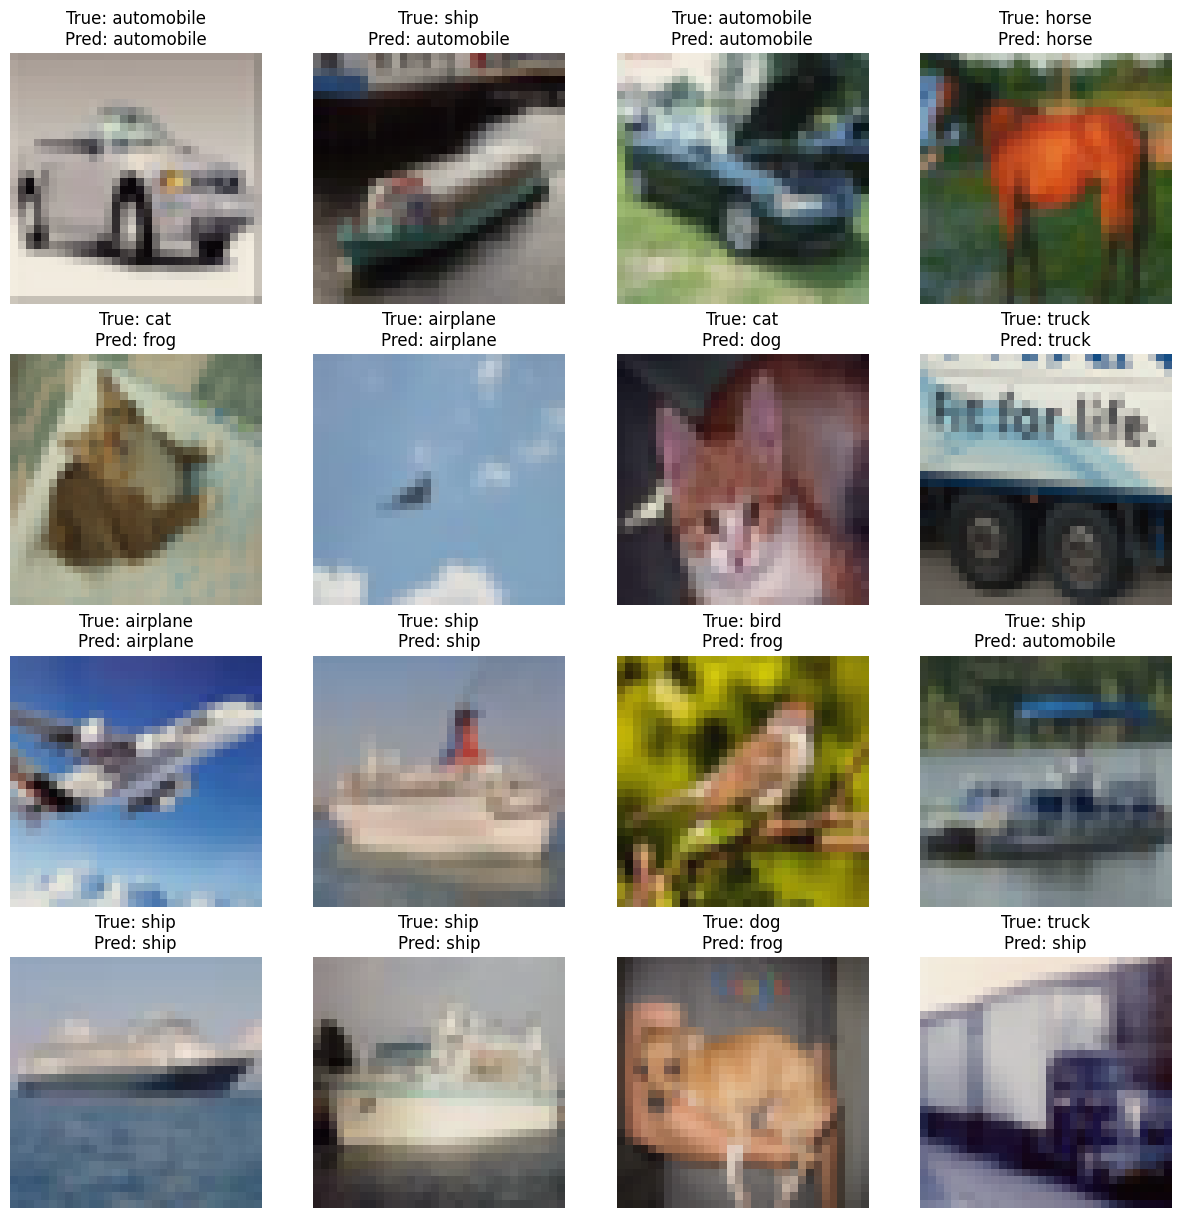

In [23]:
train_model('vit_small', 20)

Número de parámetros: 2.38 millones


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Accuracy: 0.64
Precision: 0.65
Recall: 0.64
F1 score: 0.64


  0%|          | 0/20 [00:00<?, ?it/s]


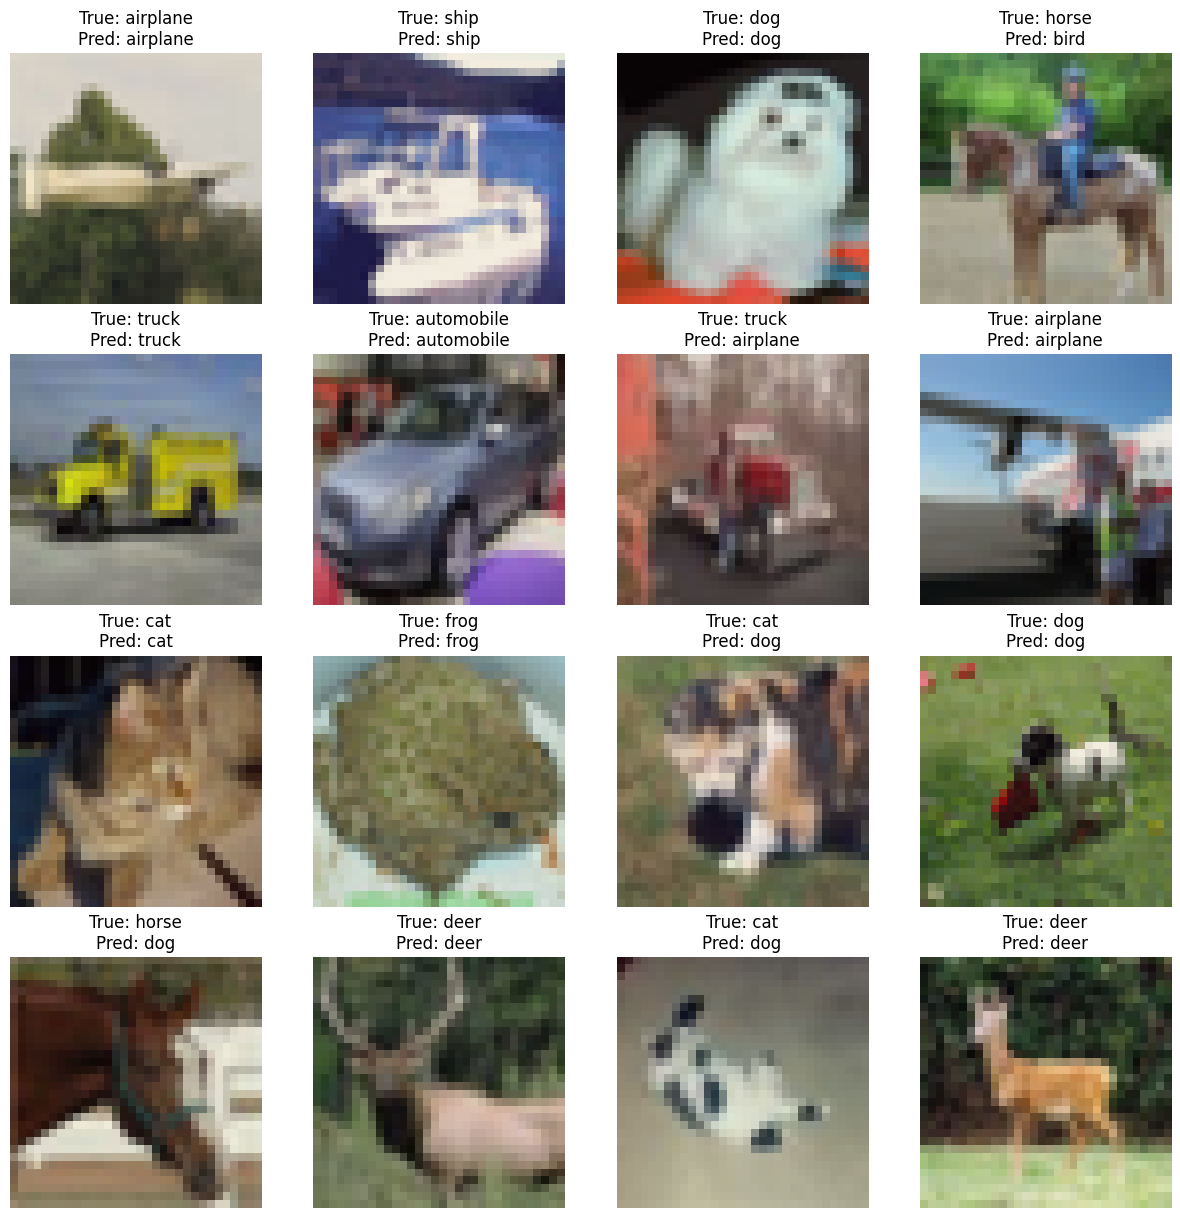

In [24]:
train_model('vit_medium', 20)

Número de parámetros: 18.92 millones


100%|██████████| 20/20 [00:43<00:00,  2.15s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.10
Precision: 0.01
Recall: 0.10
F1 score: 0.02


  0%|          | 0/20 [00:00<?, ?it/s]


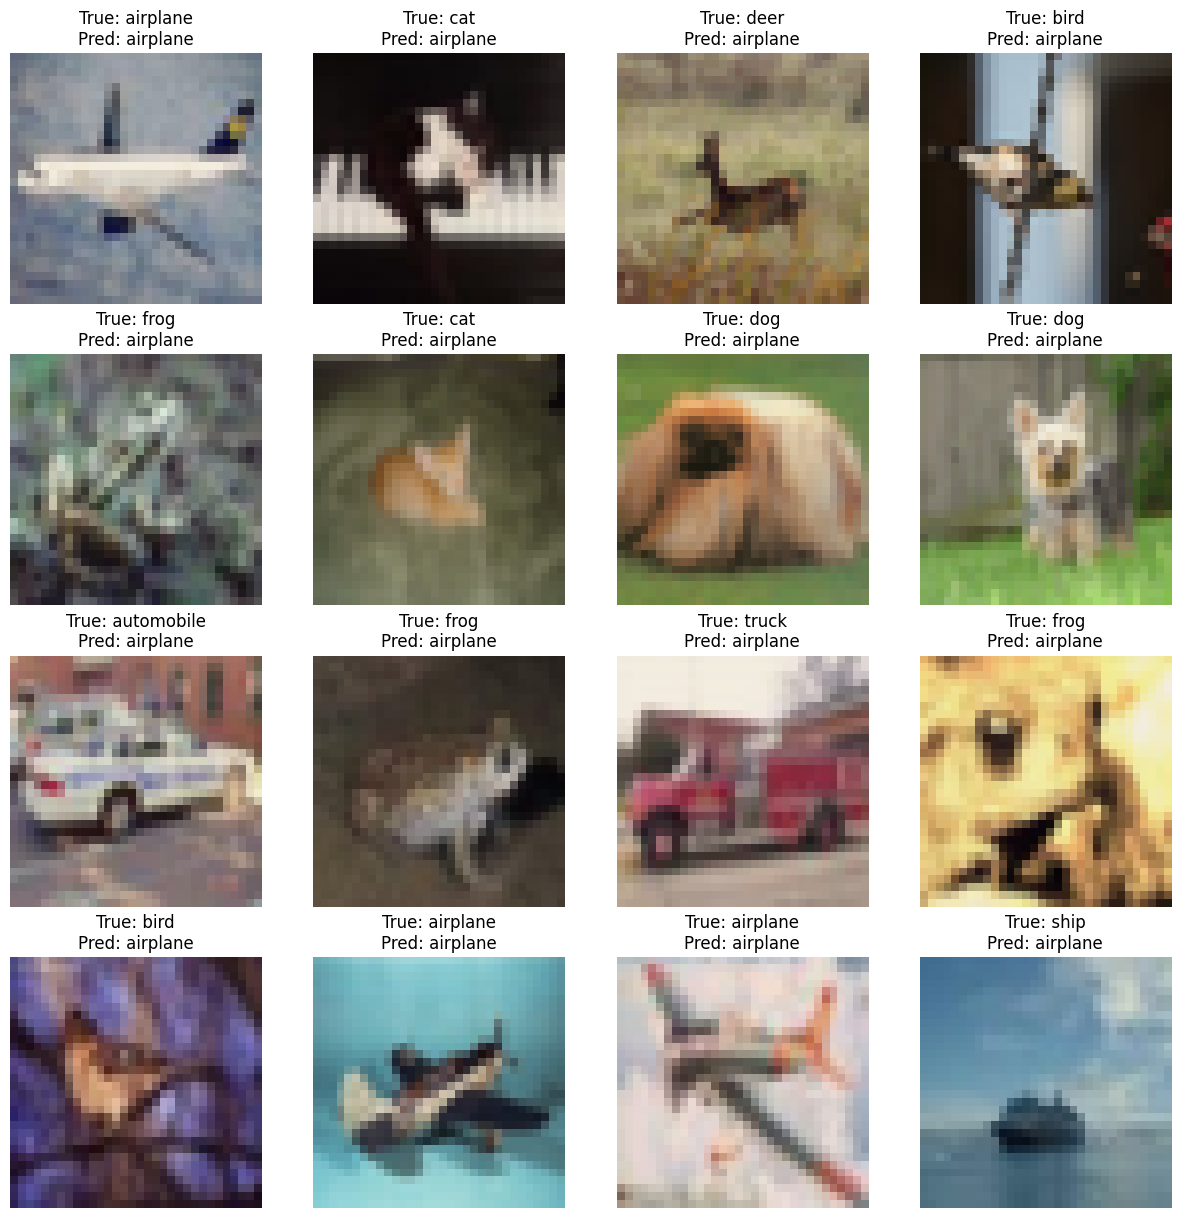

In [25]:
train_model('vit_large', 20)

# 3. Data augmentation

In [40]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

In [41]:
models = {}
for name, cfg in variants.items():
    models[name] = VisionTransformer(**common_kwargs, **cfg)

for name, m in models.items():
    total_params = sum(p.numel() for p in m.parameters())
    print(f"{name}: {total_params/1e6:.1f}M params")

vit_small: 0.3M params
vit_medium: 2.4M params
vit_large: 18.9M params


Número de parámetros: 0.30 millones


100%|██████████| 20/20 [00:05<00:00,  3.44it/s]


Accuracy: 0.63
Precision: 0.64
Recall: 0.63
F1 score: 0.63


  0%|          | 0/20 [00:00<?, ?it/s]


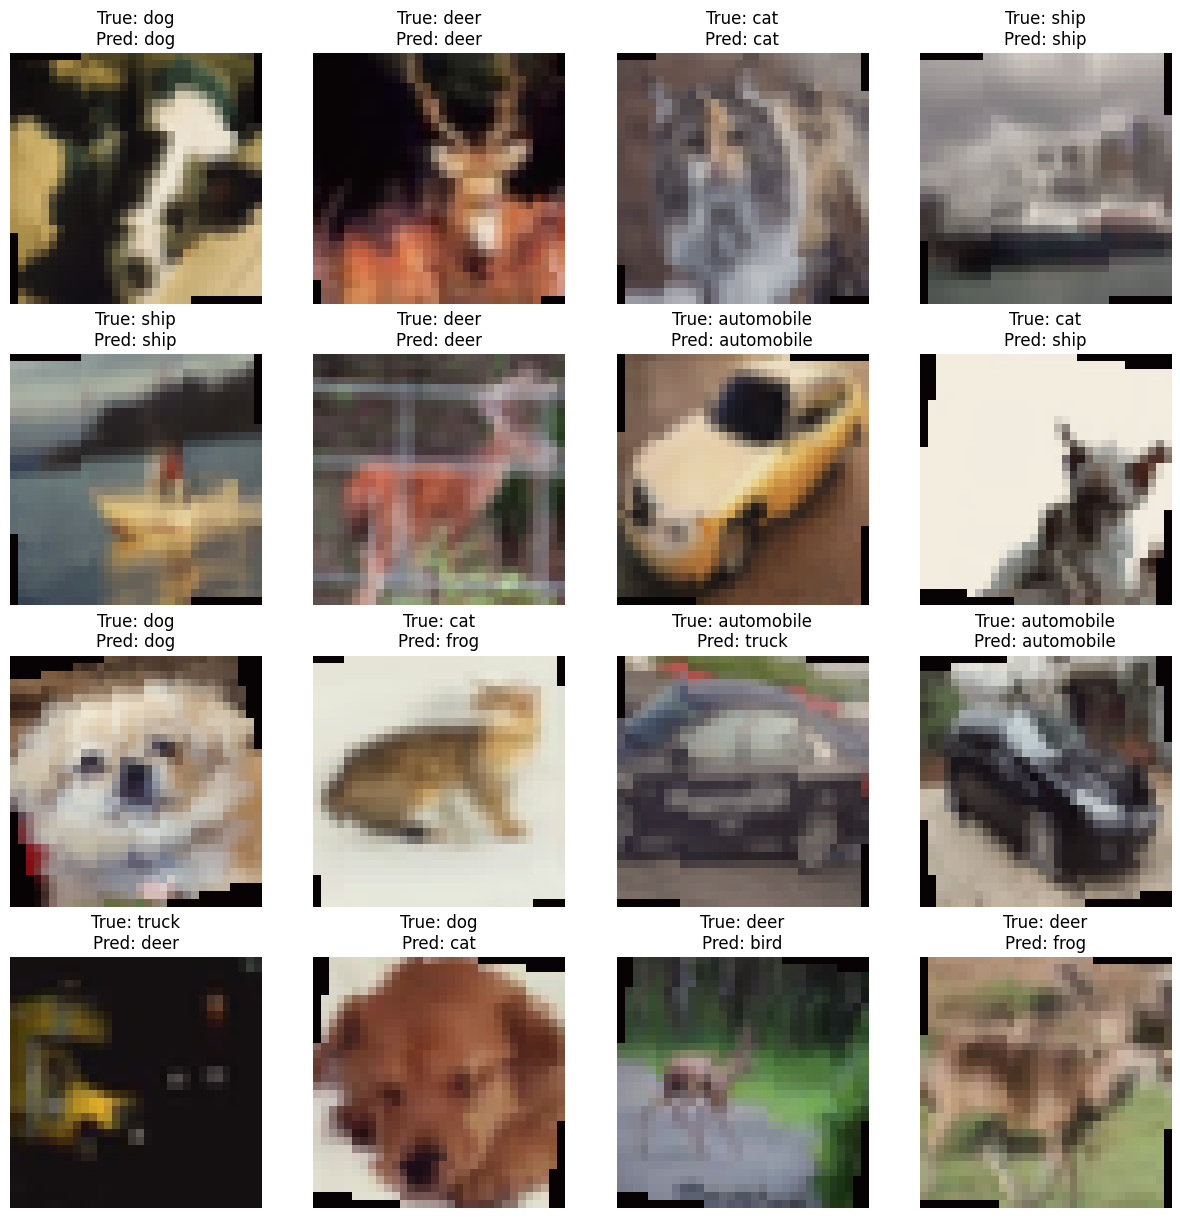

In [42]:
train_model('vit_small', 20, 1e-3)

Número de parámetros: 2.38 millones


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Accuracy: 0.65
Precision: 0.67
Recall: 0.65
F1 score: 0.65


  0%|          | 0/20 [00:00<?, ?it/s]


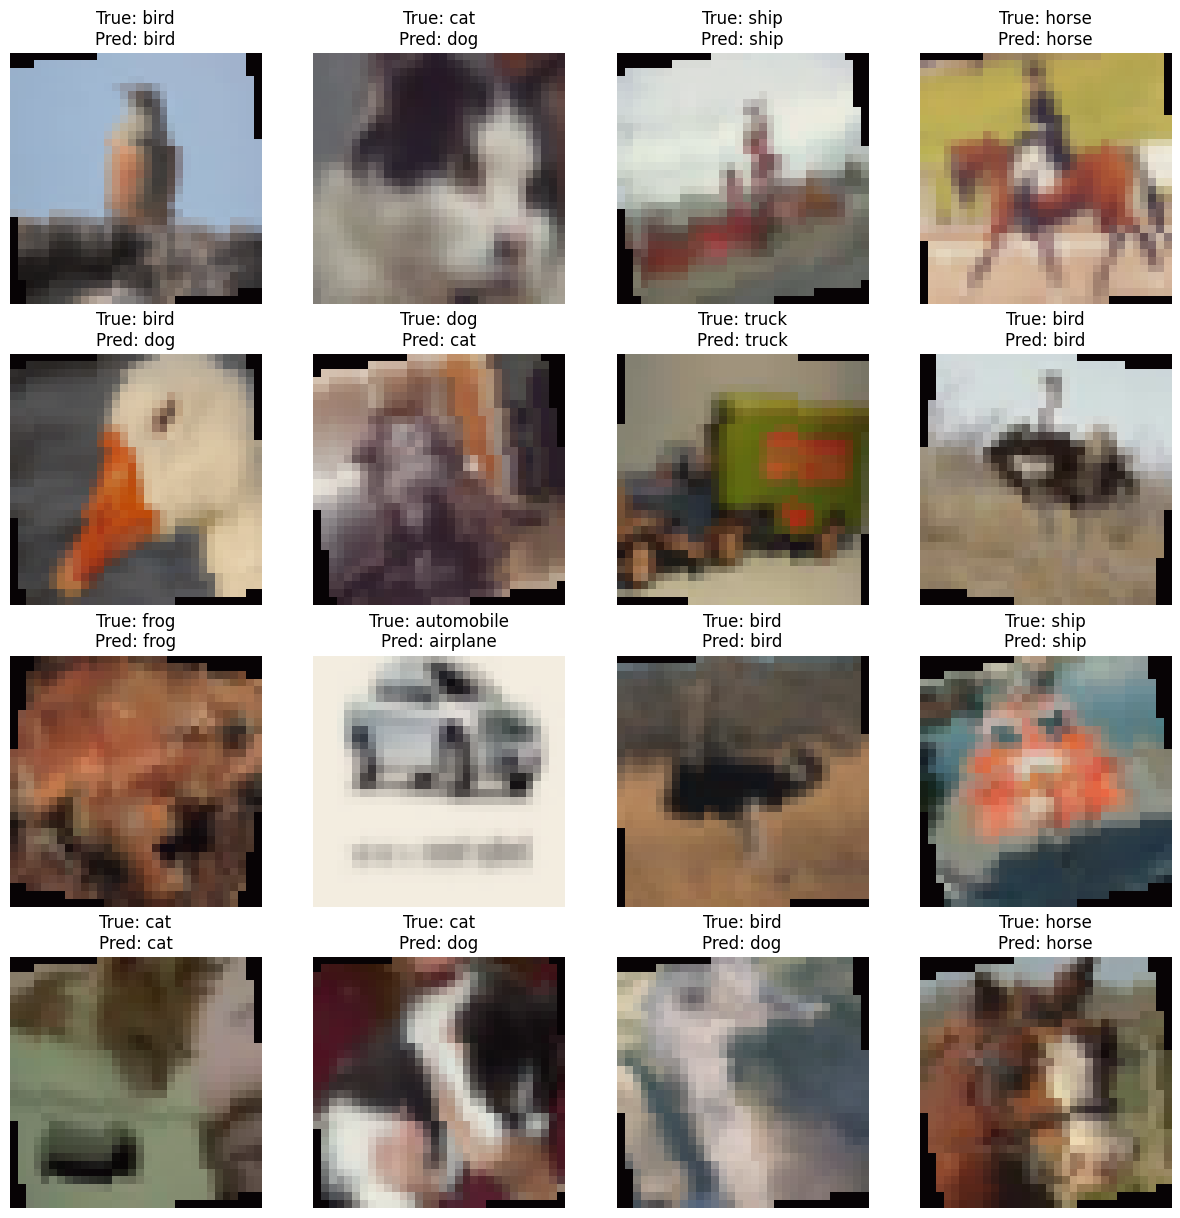

In [43]:
train_model('vit_medium', 20, 1e-3)

Número de parámetros: 18.92 millones


100%|██████████| 20/20 [00:11<00:00,  1.76it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.10
Precision: 0.01
Recall: 0.10
F1 score: 0.02


  0%|          | 0/20 [00:00<?, ?it/s]


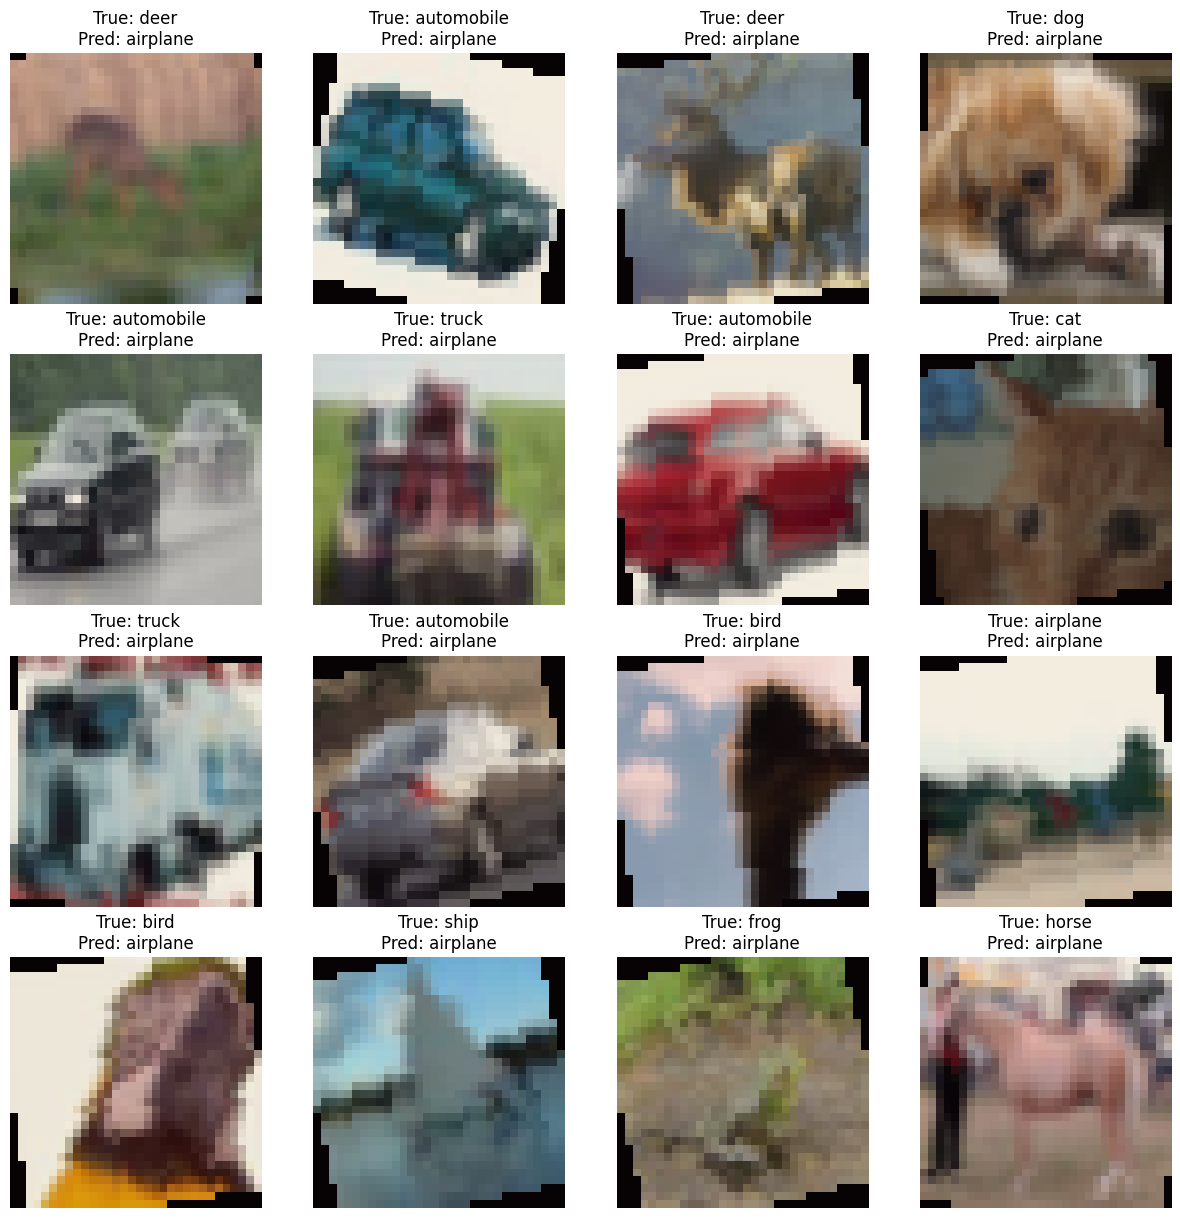

In [44]:
train_model('vit_large', 20, 1e-3)

# Conclusiones

Se evaluaron tres variantes del Vision Transformer (ViT-Small, ViT-Medium, ViT-Large) en el dataset CIFAR-10, tanto con como sin data augmentation. Los resultados se resumen en la siguiente tabla:

| Modelo       | Parámetros | Augmentation          | Accuracy | Precision | Recall | F1-Score |
|--------------|------------|-----------------------|----------|-----------|--------|----------|
| `vit_small`  | 0.3M       |  No                   | 0.60     | 0.60      | 0.60   | 0.59     |
| `vit_small`  | 0.3M       |  Si                   | 0.63     | 0.64      | 0.63   | 0.63     |
| `vit_medium` | 2.4M       |  No                   | 0.64     | 0.65      | 0.64   | 0.64     |
| `vit_medium` | 2.4M       |  Si                   | 0.65     | 0.67      | 0.65   | 0.65     |
| `vit_large`  | 18.9M      |  No                   | 0.10     | 0.01      | 0.10   | 0.02     |
| `vit_large`  | 18.9M      |  Si                   | 0.10     | 0.01      | 0.10   | 0.02     |


### Análisis por Modelo y Configuración

1.  **ViT-Small (0.3M parámetros):**
    *   **Sin Augmentation:** El modelo alcanzó un Accuracy del 60% y un F1-Score de 0.59. Las métricas de Precision (0.60) y Recall (0.60) son consistentes, lo que sugiere un aprendizaje balanceado aunque modesto.
    *   **Con Augmentation:** El rendimiento mejoró ligeramente, beneficio del data augmentation.

2.  **ViT-Medium (2.4M parámetros):**
    *   **Sin Augmentation:** Este modelo superó al ViT-Small con y sin augmentation, logrando un Accuracy del 64% y un F1-Score de 0.64. Esto indica que el aumento en la capacidad del modelo permitió un mejor aprendizaje de las características del dataset.
    *   **Con Augmentation:** El ViT-Medium con data augmentation mostró el mejor rendimiento general entre las configuraciones completadas, alcanzando un Accuracy del 65% y un F1-Score de 0.65.

3.  **ViT-Large (18.9M parámetros):**
    *   **Sin Augmentation:** Este modelo tuvo un desempeño extremadamente bajo, con un Accuracy del 10% y un F1-Score de 0.02. Estos resultados son comparables a una clasificación aleatoria en CIFAR-10.
    *   **Con Augmentation:** Sorprendentemente, el data augmentation no produjo ninguna mejora en el `vit_large`. El modelo siguió obteniendo un Accuracy del 10% y un F1-Score de 0.02. Esto indica que los problemas de aprendizaje del `vit_large` en este dataset con 20 épocas son más profundos que la simple falta de diversidad de datos.

### Conclusiones Generales

*   **Impacto del Tamaño del Modelo:**
    Al comparar los modelos sin data augmentation, pasar de `vit_small` a `vit_medium` resultó en una mejora en el rendimiento (Accuracy del 60% al 64%). Sin embargo, `vit_large` no logró aprender, lo que sugiere que para datasets del tamaño de CIFAR-10 (50,000 imágenes de entrenamiento), los modelos ViT más grandes son muy susceptibles al sobreajuste y requieren una regularización mucho más fuerte, preentrenamiento en datasets más grandes, o un ajuste más cuidadoso de hiperparámetros y más épocas de entrenamiento.
    Cuando se utiliza data augmentation, el `vit_medium` (65% Accuracy) también superó al `vit_small` (63% Accuracy), manteniendo la tendencia de que un modelo de tamaño intermedio puede ser más adecuado para este dataset bajo las condiciones de entrenamiento dadas.

*   **Impacto del Data Augmentation:**
    El data augmentation demostró ser beneficioso para las variantes `vit_small` y `vit_medium`, mejorando el Accuracy y el F1-Score en ambos casos (de 60% a 63% para small, y de 64% a 65% para medium). Esto resalta la importancia de aumentar la diversidad del dataset de entrenamiento para ayudar a los Vision Transformers a generalizar mejor y reducir el sobreajuste.